In [1]:
import pandas as pd

order_reviews_df = pd.read_csv('../data/order_reviews.csv')

order_reviews_df['review_comment'] = order_reviews_df['review_comment_title'].fillna('') + ' ' + order_reviews_df['review_comment_message'].fillna('')

order_reviews_df = order_reviews_df[order_reviews_df['review_comment'].str.strip() != '']
order_reviews_df = order_reviews_df[['review_comment', 'review_score']]
order_reviews_df.head(10)

,review_comment,review_score
3,Recebi bem antes do prazo estipulado.,5
4,Parabéns lojas lannister adorei comprar pela ...,5
9,recomendo aparelho eficiente. no site a marca ...,4
12,"Mas um pouco ,travando...pelo valor ta Boa.\r\n",4
15,"Super recomendo Vendedor confiável, produto ok...",5
16,"GOSTARIA DE SABER O QUE HOUVE, SEMPRE RECEBI ...",2
19,Não chegou meu produto Péssimo,1
22,Ótimo Loja nota 10,5
24,obrigado pela atençao amim dispensada,5
27,A compra foi realizada facilmente.\r\nA entre...,5


In [2]:
import torch
from transformers import RobertaTokenizer, RobertaForSequenceClassification

order_reviews_df = order_reviews_df[['review_comment', 'review_score']]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Використовується пристрій: {device}")

tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

model_path = "new_data_task3/model_training_results/checkpoint-6000"
model = RobertaForSequenceClassification.from_pretrained(model_path)
model.to(device) 

def batch_predict_sentiment(texts):
    # Токенизація текстів
    inputs = tokenizer(texts, padding="max_length", truncation=True, max_length=128, return_tensors='pt').to(device)
    
    outputs = model(**inputs)
    
    predicted_classes = torch.argmax(outputs.logits, dim=1).tolist()
    # Перетворення индексів  від 1 до 5
    predicted_scores = [pred_class + 1 for pred_class in predicted_classes]
    return predicted_scores

batch_size = 256
batches = [order_reviews_df[i:i+batch_size] for i in range(0, len(order_reviews_df), batch_size)]

# Передача пакетів для прогнозу
predicted_scores = []
for batch_df in batches:
    batch_texts = batch_df['review_comment'].tolist()
    batch_scores = batch_predict_sentiment(batch_texts)
    predicted_scores.extend(batch_scores)

order_reviews_df['model_evaluation'] = predicted_scores
order_reviews_df.head()

Використовується пристрій: cuda


c:\Users\Микола\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


,review_comment,review_score,model_evaluation
3,Recebi bem antes do prazo estipulado.,5,5
4,Parabéns lojas lannister adorei comprar pela ...,5,5
9,recomendo aparelho eficiente. no site a marca ...,4,5
12,"Mas um pouco ,travando...pelo valor ta Boa.\r\n",4,4
15,"Super recomendo Vendedor confiável, produto ok...",5,5


In [37]:
print(len(order_reviews_df['model_evaluation']))

43463


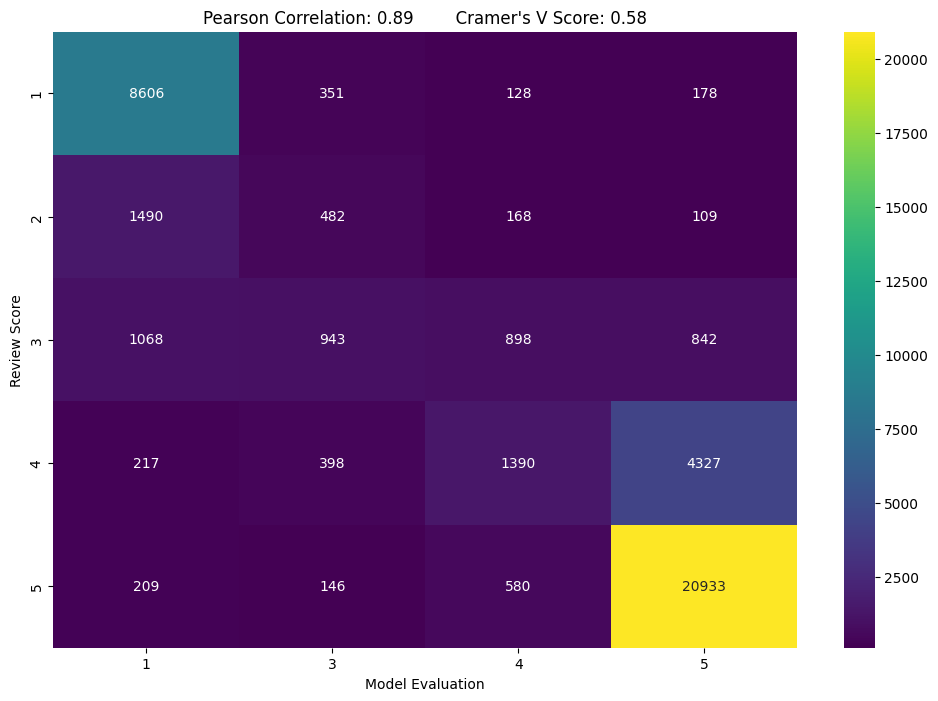

In [43]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

contingency_table = pd.crosstab(order_reviews_df['review_score'], order_reviews_df['model_evaluation'])

# Визначення кореляції Пірсона
pearson_corr = order_reviews_df['review_score'].corr(order_reviews_df['model_evaluation'])

# Використання коефіцієнту V Крамера для оцінки асоціації
def cramers_v(table):
    chi2 = chi2_contingency(table)[0]
    n = table.sum().sum()
    phi2 = chi2 / n
    r, k = table.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

cramers_v_score = cramers_v(contingency_table)

plt.figure(figsize=(12, 8))
sns.heatmap(contingency_table, annot=True, cmap='viridis', fmt='d')
plt.title(f'Pearson Correlation: {pearson_corr:.2f}        Cramer\'s V Score: {cramers_v_score:.2f}')
plt.xlabel('Model Evaluation')
plt.ylabel('Review Score')

plt.savefig('new_data_task3/Text_Score_Correlation.png', bbox_inches='tight')

plt.show()